In [1]:
import pandas as pd
from glob import glob
import os
import shutil
import json
from PIL import Image
import numpy as np
from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt

# Settings
isSampleAvailable = True  # Set to True if sample files already exist else False

### Data Sampling

In [2]:
if(not isSampleAvailable):
    df_e = pd.read_json("../Data/Extended/ex_train.jsonl", lines=True)

    # a sample of 200 examples from extended dataset
    df_e = df_e.sample(200, random_state=42)
    df_e.sort_values(by="id", inplace=True)

    os.makedirs("Sample", exist_ok=True)
    df_e.to_json("Sample/tr_ext_sample.jsonl", orient="records", lines=True)

In [3]:
if(not isSampleAvailable):
    df_o = pd.read_json("../Data/Original/train.jsonl", lines=True)

    df_o = df_o[df_o['id'].isin(df_e['id'].values)]
    df_o.sort_values(by="id", inplace=True)

    os.makedirs("Sample", exist_ok=True)
    df_o.to_json("Sample/tr_orig_sample.jsonl", orient="records", lines=True)

In [4]:
if(not isSampleAvailable):
    os.makedirs("Sample/img", exist_ok=True)
    for p_o, p_e in zip(df_o['img'], df_e['img']):
        shutil.copy(f"../Data/Original/{p_o}", "Sample/img/")
        shutil.copy(f"../Data/Extended/{p_e}", "Sample/img/")

### Data Annotation

In [5]:
df_e = pd.read_json("Sample/tr_ext_sample.jsonl", lines=True)
df_o = pd.read_json("Sample/tr_orig_sample.jsonl", lines=True)

In [6]:
try:
    with open("annotations.json", "r") as f:
        data = json.load(f)
except FileNotFoundError:
    data = {}

for i in range(len(df_e)):
    id = df_e.iloc[i]['id']
    print(f"### Original Data Caption ###: {df_o.iloc[i]['text']}")
    image_orig = Image.open(f"Sample/{df_o.iloc[i]['img']}")
    image_orig = image_orig.resize((400, int(400 * image_orig.height / image_orig.width)))
    image_orig.show()

    print(f"### Augmented Caption ###: {df_e.iloc[i]['text']}")
    image_ext = Image.open(f"Sample/{df_e.iloc[i]['img']}")
    image_ext = image_ext.resize((400, int(400 * image_ext.height / image_ext.width)))
    image_ext.show()
    
    # inputs for human evaluation
    if id not in data:
        # Questions for Original Meme
        isMemeHateful = int(input("Is the original meme hateful? (1: yes/0: no): "))
        isMemeBackHateful = int(input("Is the original meme background hateful? (1: yes/0: no): "))
        isMemeCaptionHateful = int(input("Are the original caption hateful? (1: yes/0: no): "))

        # Questions for New Non-hateful Meme
        isNewMemeHateful = int(input("Is the new meme hateful? (1: yes/0: no): "))
        isNewMemeBackHateful = int(input("Is the new meme background hateful? (1: yes/0: no): "))
        isNewMemeCaptionHateful = int(input("Are the new caption hateful? (1: yes/0: no): "))

        memeFormattingQuality = int(input("How is the meme formatting quality? (0-5): "))
        isNewBackAligned = int(input("Is the new background aligned with the old background? (0-5): "))
        isNewCaptionAlignedWithNewBack = int(input("Is the new caption aligned with the new background? (0-5): "))

        overAllQuality = int(input("How is the overall quality of the new meme? (0-5): "))

        data[id] = {
            "isMemeHateful": isMemeHateful,
            "isMemeBackHateful": isMemeBackHateful,
            "isMemeCaptionHateful": isMemeCaptionHateful,
            "isNewMemeHateful": isNewMemeHateful,
            "isNewMemeBackHateful": isNewMemeBackHateful,
            "isNewMemeCaptionHateful": isNewMemeCaptionHateful,
            "memeFormattingQuality": memeFormattingQuality,
            "isNewBackAligned": isNewBackAligned,
            "isNewCaptionAlignedWithNewBack": isNewCaptionAlignedWithNewBack,
            "overAllQuality": overAllQuality
        }

        # Save the annotations after each iteration
        with open("annotations.json", "w") as f:
            json.dump(data, f, indent=4)

    clear_output(wait=True)

print("Annotations saved successfully! Thank you for your participation.")

Annotations saved successfully! Thank you for your participation.


### Analysis

In [2]:
with open("annotations.json", "r") as f:
    anno_data = json.load(f)

In [3]:
keys = [
    "isMemeHateful",
    "isMemeBackHateful",
    "isMemeCaptionHateful",
    "isNewMemeHateful",
    "isNewMemeBackHateful",
    "isNewMemeCaptionHateful",
    "memeFormattingQuality",
    "isNewBackAligned",
    "isNewCaptionAlignedWithNewBack",
    "overAllQuality"
]

fields = {key: [item[key] for item in anno_data.values()] for key in keys}

# *removed the score -1 in case of no caption on the image: isNewCaptionAlignedWithNewBack
print("The number of meme samples with no caption on the image: ", end="")
nNoCap = len([i for i in fields["isNewCaptionAlignedWithNewBack"] if i == -1])
print(nNoCap, "i.e., ", nNoCap/len(anno_data), "of total samples.")

fields["isNewCaptionAlignedWithNewBack"] = [i for i in fields["isNewCaptionAlignedWithNewBack"] if i != -1]

print("### Human Evaluation Results ###")
print("-" * 60)
print(f"{'Metric':40s} | {'Avr':>6s} | {'Std Dev':>7s}")
print("-" * 60)
for key in keys:
    values = fields[key]
    mean = np.mean(values)
    std = np.std(values)
    print(f"{key:40s} | {mean:6.3f} | {std:7.3f}")
print("-" * 60)

The number of meme samples with no caption on the image: 7 i.e.,  0.035 of total samples.
### Human Evaluation Results ###
------------------------------------------------------------
Metric                                   |    Avr | Std Dev
------------------------------------------------------------
isMemeHateful                            |  1.000 |   0.000
isMemeBackHateful                        |  0.000 |   0.000
isMemeCaptionHateful                     |  1.000 |   0.000
isNewMemeHateful                         |  0.000 |   0.000
isNewMemeBackHateful                     |  0.000 |   0.000
isNewMemeCaptionHateful                  |  0.000 |   0.000
memeFormattingQuality                    |  4.050 |   0.926
isNewBackAligned                         |  4.180 |   0.887
isNewCaptionAlignedWithNewBack           |  4.425 |   0.745
overAllQuality                           |  3.975 |   0.863
------------------------------------------------------------


/tmp/ipykernel_342116/1938559339.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/tmp/ipykernel_342116/1938559339.py:25: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax = sns.violinplot(


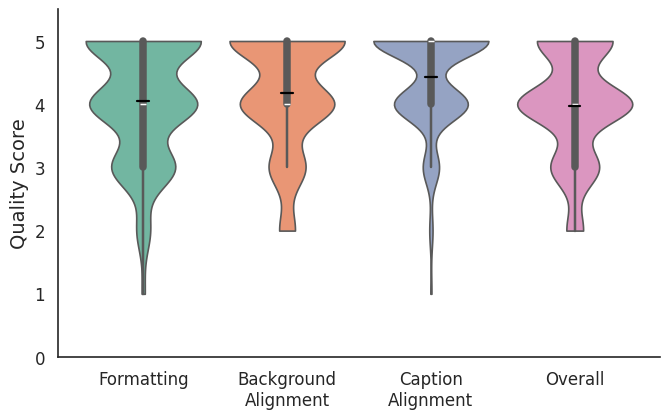

In [7]:
data = fields["memeFormattingQuality"] + fields["isNewBackAligned"] + fields["isNewCaptionAlignedWithNewBack"] + fields["overAllQuality"]

# Create corresponding x-axis labels for each value
labels = (['Formatting'] * len(fields["memeFormattingQuality"]) + 
          ['Background\nAlignment'] * len(fields["isNewBackAligned"]) + 
          ['Caption\nAlignment'] * len(fields["isNewCaptionAlignedWithNewBack"]) + 
          ['Overall'] * len(fields["overAllQuality"]))

# Group data for mean plotting
grouped = {
    "Formatting": fields["memeFormattingQuality"],
    "Background\nAlignment": fields["isNewBackAligned"],
    "Caption\nAlignment": fields["isNewCaptionAlignedWithNewBack"],
    "Overall": fields["overAllQuality"]
}

# Plot settings
plt.figure(figsize=(7, 4.5))
sns.set_theme(style="white", font_scale=1.4)

# Classy pastel colors
palette = sns.color_palette("Set2")

# Violin plot
ax = sns.violinplot(
    x=labels,
    y=data,
    cut=0,
    linewidth=1.2,
    palette=palette,
)

# Overlay black mean line per violin
for i, (label, values) in enumerate(grouped.items()):
    mean_val = np.mean(values)
    ax.plot([i - 0.04, i + 0.04], [mean_val, mean_val], color='black', linewidth=1.6)

# Aesthetic clean-up
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

plt.ylim(0, 5.5)
plt.yticks([0, 1, 2, 3, 4, 5], fontsize=12)
plt.xticks(fontsize=12, rotation=0)

plt.ylabel("Quality Score", fontsize=14)
# plt.xlabel("Quality Aspect", fontsize=14)
plt.tight_layout()
plt.savefig("human_eval_results.pdf", dpi=300, bbox_inches='tight')
plt.show()